# Basic Usage of QuantLib analytics library
## More details at: https://quantlib-python-docs.readthedocs.io/en/latest/

In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


## 1. Objects and Handles
### a. Define a quote object and inspect the value.

In [2]:
quote = ql.SimpleQuote(.01)
print(quote.value())

quote.setValue(.02)
print(quote.value())

0.01
0.02


### b. Define quoteHandle as a handle/smart pointer to the quote object.

In [3]:
quoteHandle = ql.QuoteHandle(quote)
quoteHandle.value()

0.02

### c. When the quote object is changed, the quoteHandle changes value as well.

In [4]:
quote = 0.05
quoteHandle.value()

0.02

### d. Calendars and day-count conventions

In [5]:
# dates
todays_date = ql.Date.todaysDate()
test_date = todays_date + 90
print('todays_date =', todays_date)
print('test_date =', test_date)


# calendars
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
holiday_list = list(calendar.holidayList(todays_date, test_date))
print('holiday_list =', holiday_list)


# day count conventions
day_count = ql.Actual360()
print('day_count =', day_count)

# year fractions
test_year_fraction = day_count.yearFraction(todays_date, test_date)
print('Year Fraction [ from', todays_date, 'to', test_date,'] =', test_year_fraction)

todays_date = May 2nd, 2023
test_date = July 31st, 2023
holiday_list = [Date(29,5,2023), Date(19,6,2023), Date(4,7,2023)]
day_count = Actual/360 day counter
Year Fraction [ from May 2nd, 2023 to July 31st, 2023 ] = 0.25


## 2. Cashflow Schedules
### a. Construct a semi-annual fixed rate cashflow schedule object.

In [6]:
issue_date = ql.Date(17, 12, 2022)
maturity_date = ql.Date(17, 12, 2027)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end)

### b. Inspect the cashflow schedule
- Use list() to get a list of all the dates in Schedule, and len() to get number of dates
- Use [] for random access
- use startDate(), endDate()

In [7]:
print("All dates: ", list(schedule))
print("Length: ", len(schedule))
print("The 3rd coupon date: ", schedule[3])  # random access
print("Start Date: ", schedule.startDate())
print("End Date: ", schedule.endDate())

All dates:  [Date(17,12,2022), Date(17,6,2023), Date(17,12,2023), Date(17,6,2024), Date(17,12,2024), Date(17,6,2025), Date(17,12,2025), Date(17,6,2026), Date(17,12,2026), Date(17,6,2027), Date(17,12,2027)]
Length:  11
The 3rd coupon date:  June 17th, 2024
Start Date:  December 17th, 2022
End Date:  December 17th, 2027


## 3. Discount Curve / Yield Curve Term Structure
### a. Constructing a Flat Yield Curve

In [8]:
# Set the static valuation date
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous # continously compounded rate of 5%
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

### b. Inspect the discount curve

In [9]:
ref_date = flat_yield_curve.referenceDate()
test_date = ql.Date(31, 12, 2023)

# calc year fraction between ref_date and test_date
yearFrac = flat_yield_curve.dayCounter().yearFraction(ref_date, test_date)

print("Reference Date =", ref_date)
print("Test Date =", test_date)
print("Year Fraction between Reference Date and Test Date : ", yearFrac)
print("Discount Factor for Test Date", test_date, ": ", flat_yield_curve.discount(test_date))
print("Manual DF calculation for Test Date", test_date, ": ", np.exp(-flat_rate.value() * yearFrac))
print("Difference in Discount Factor:", flat_yield_curve.discount(test_date) - np.exp(-flat_rate.value() * yearFrac))



Reference Date = April 14th, 2023
Test Date = December 31st, 2023
Year Fraction between Reference Date and Test Date :  0.725
Discount Factor for Test Date December 31st, 2023 :  0.9643991635522495
Manual DF calculation for Test Date December 31st, 2023 :  0.9643991635522495
Difference in Discount Factor: 0.0


## 4. Fixed Rate Bonds
### a. Constructing a fixed rate bond object

In [10]:
coupon_rate = 0.04
day_count = ql.Thirty360(ql.Thirty360.USA)
coupons = [coupon_rate]
payment_convention = ql.Unadjusted

# Construct the FixedRateBond
settlement_days = 1
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count,
    payment_convention)

### b. Investigate the bond cash-flows

In [11]:
x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)

           CashFlowDate  CashFlowAmount
0       June 17th, 2023             2.0
1   December 17th, 2023             2.0
2       June 17th, 2024             2.0
3   December 17th, 2024             2.0
4       June 17th, 2025             2.0
5   December 17th, 2025             2.0
6       June 17th, 2026             2.0
7   December 17th, 2026             2.0
8       June 17th, 2027             2.0
9   December 17th, 2027             2.0
10  December 17th, 2027           100.0


## 5. Bond Present Value Calculation (no credit risk)
### a. Direct function call using risk-free bond pricing engine

In [12]:
bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)
fixed_rate_bond.setPricingEngine(bond_engine)
pv_engine = fixed_rate_bond.NPV()
pv_engine

96.61211292221057

### b. Manual Calculation to verify PV

In [13]:
calc_frame = cf_frame
discount_yearfrac = np.zeros((len(calc_frame,)))
discount_factor = np.zeros((len(calc_frame,)))

i = 0
for cf_date in calc_frame['CashFlowDate']:
    discount_yearfrac[i] = flat_yield_curve.dayCounter().yearFraction(flat_yield_curve.referenceDate(), cf_date)
    discount_factor[i] = flat_yield_curve.discount(cf_date)
    i += 1

calc_frame['YearFrac'] = discount_yearfrac
calc_frame['DiscountFactor'] = discount_factor
calc_frame['NPV'] = calc_frame['CashFlowAmount'] * calc_frame['DiscountFactor']

calc_frame

,CashFlowDate,CashFlowAmount,YearFrac,DiscountFactor,NPV
0,"June 17th, 2023",2.0,0.177778,0.991151,1.982301
1,"December 17th, 2023",2.0,0.686111,0.966276,1.932552
2,"June 17th, 2024",2.0,1.194444,0.942026,1.884052
3,"December 17th, 2024",2.0,1.702778,0.918385,1.836769
4,"June 17th, 2025",2.0,2.208333,0.895461,1.790922
5,"December 17th, 2025",2.0,2.716667,0.872988,1.745976
6,"June 17th, 2026",2.0,3.222222,0.851197,1.702395
7,"December 17th, 2026",2.0,3.730556,0.829836,1.659671
8,"June 17th, 2027",2.0,4.236111,0.809122,1.618244
9,"December 17th, 2027",2.0,4.744444,0.788816,1.577632


In [14]:
pv_manual = calc_frame['NPV'].sum()
print('NPV_Engine = ', pv_engine)
print('NPV_Manual = ', pv_manual)
print('NPV diff = ', pv_manual - pv_engine)

NPV_Engine =  96.61211292221057
NPV_Manual =  96.61211292221057
NPV diff =  0.0


### c. Bond Clean vs Dirty Prices

In [15]:
print('Bond Notional = ', fixed_rate_bond.notional())
print('Settle Date = ', fixed_rate_bond.settlementDate())
print('Discount Factor to Settle Date = ', round(flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond NPV (Calc Date) = ', round(fixed_rate_bond.NPV(), 4))
print('Bond NPV Adjusted to Settle Date = ', round(fixed_rate_bond.NPV() / flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond Dirty Price = ', round(fixed_rate_bond.dirtyPrice(), 4))
print('Bond Clean Price = ', round(fixed_rate_bond.cleanPrice(), 4))
print('Bond Accrued = ', round(fixed_rate_bond.accruedAmount(), 4))


Bond Notional =  100.0
Settle Date =  April 17th, 2023
Discount Factor to Settle Date =  0.9996
Bond NPV (Calc Date) =  96.6121
Bond NPV Adjusted to Settle Date =  96.6524
Bond Dirty Price =  96.6524
Bond Clean Price =  95.319
Bond Accrued =  1.3333


## 6. Market Data Scenarios
### a. Apply +/-1bp parallel shift scenarios in interest rates curve and compute scenario prices

In [16]:
# start with interest_rate_bump = 0
interest_rate_bump = ql.SimpleQuote(0.0)
flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(flat_yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
fixed_rate_bond.setPricingEngine(bond_engine)

price_base = fixed_rate_bond.cleanPrice()

# Original price (zero interest rate bump)
print("Price (base case): ", round(price_base, 4))

# Bump interest rate by +1bps (parallel shift)
interest_rate_bump.setValue(0.0001)
price_up_1bp = fixed_rate_bond.cleanPrice()
print("Price in +1bps scenario:: ", round(price_up_1bp, 4))
print("Price diff in +1bps scenario:: ", round(price_up_1bp - price_base, 6))

# Bump interest rate by -1bps (parallel shift)
interest_rate_bump.setValue(-0.0001)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Price for -1bps scenario:", round(price_down_1bp, 4))
print("Price diff in -1bps scenario:: ", round(price_down_1bp - price_base, 6))

 # Remove interest rate bump
interest_rate_bump.setValue(0)



Price (base case):  95.319
Price in +1bps scenario::  95.2775
Price diff in +1bps scenario::  -0.041529
Price for -1bps scenario: 95.3606
Price diff in -1bps scenario::  0.041548


 ### b. Compute scenario DV01, duration and convexity

In [17]:
# Compute scenario delta/gamma sensitivities
dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
duration = round(dv01 / fixed_rate_bond.dirtyPrice() * 100, 4)
gamma_1bp = (price_down_1bp - 2*price_base + price_up_1bp) * 1e8 / 100
convexity = round(gamma_1bp / fixed_rate_bond.dirtyPrice() * 100, 4)

print("DV01: ", dv01)
print("Duration: ", duration)
print("Convexity: ", convexity)




DV01:  4.1548
Duration:  4.2987
Convexity:  19.714


## 7. Yield to Price conversions


In [18]:
# Use original interest rate yield of 5%
# flat_rate.setValue(0.05)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.NPV(), 4))


# Change interest rate yield to 6% and recompute bond PV
flat_rate.setValue(0.06)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.NPV(), 4))

# Set interest rate yield back to 5%
flat_rate.setValue(0.05)

Bond PV for 5.0 pct yield: 96.6121
Bond PV for 6.0 pct yield: 92.546


## 8. Price to Yield conversions


In [19]:
# bond_market_price = fixed_rate_bond.cleanPrice()
bond_market_price = 95.00   # Clean market price

compounding = ql.Compounded
# compounding = ql.Continuous

settle_date = fixed_rate_bond.settlementDate(calc_date)
day_counter = fixed_rate_bond.dayCounter()

print('day_counter =', day_counter)
print('coupon_freq =', coupon_freq)
print('calc_date =', calc_date)
print('settle_date =', settle_date)


implied_yield = fixed_rate_bond.bondYield(bond_market_price, day_counter, compounding, coupon_freq, settle_date) * 100
print('implied_yield =', round(implied_yield, 4))

day_counter = 30/360 (US) day counter
coupon_freq = 2
calc_date = April 14th, 2023
settle_date = April 17th, 2023
implied_yield = 5.2197


## 9. Analytical Duration, Convexity and Z-Spread (flat yield model)

### a. Compute bond duration, convexity and Z-Spread

In [36]:
# flat_bond_yield (used as an input to compute duration and convexity)
flat_bond_yield = 5.5 # in pct
flat_bond_yield_rate = ql.InterestRate(flat_bond_yield/100, day_count, compounding, coupon_freq)

# Calc Duration and Convexity
bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_bond_yield_rate)

# Calc z-spread for a given market price
bond_market_price = 95.3194     # Clean market price, implies zero Z-Spread!
bond_market_price = 95          # Test market price, implies Z-Spread > 0
bond_zspread = ql.BondFunctions.zSpread(fixed_rate_bond, bond_market_price, flat_yield_curve, day_count, compounding, coupon_freq, settle_date)

# Print results
print('Bond Duration =', bond_duration)
print('Bond Convexity =', bond_convexity)
print('Bond Z-Spread bps =', round(bond_zspread * 10000, 2))


Bond Duration = 4.1170520484084046
Bond Convexity = 20.1090338964561
Bond Z-Spread bps = 7.89


### b. Validate Z-Spread

In [21]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [22]:
# Compare the original and the z-spread computed clean prices
bond_zspread_price = calc_clean_price_with_zspread(fixed_rate_bond, flat_yield_curve_handle, bond_zspread)

print('Bond Z-Spread bps =', round(bond_zspread * 10000, 2))
print('bond_market_price =', bond_market_price)
print('bond_zspread_price =', bond_zspread_price)
print('bond price diff =', bond_zspread_price - bond_market_price)

Bond Z-Spread bps = 7.89
bond_market_price = 95
bond_zspread_price = 95.00000000000031
bond price diff = 3.126388037344441e-13


## 10. Treasury Yield Curve Calibration (via Bootstrapping)
### a. Calibrate treasury flat yield curve (simple case of one calibration instrument)

In [23]:
# clean price quote
tsy_clean_price_quote = 96.0
tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))

# Create BondHelper object
bond_helper = ql.BondHelper(
    tsy_clean_price_handle,
    fixed_rate_bond)

bond_helper_list = [bond_helper]
        
tsy_flat_yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helper_list, day_count)
tsy_flat_yield_curve.enableExtrapolation()
    

### b. Display the calibrated Treasury discount curve dataframe

In [24]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [25]:
# Display Treasury yield curve details
tsy_flat_yield_curve_simple_df = get_yield_curve_details_df(tsy_flat_yield_curve)                  # using calibration grid
print(tsy_flat_yield_curve_simple_df)

grid_dates = [tsy_flat_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]
tsy_flat_yield_curve_details_df = get_yield_curve_details_df(tsy_flat_yield_curve, grid_dates)    # using external grid
print(tsy_flat_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-04-14     0.000           1.000     5.031
1  2027-12-17     4.675           0.795     5.031
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-04-14       0.0           1.000     5.031
1   2025-04-14       2.0           0.906     5.031
2   2027-04-14       4.0           0.822     5.031
3   2029-04-14       6.0           0.745     5.031
4   2031-04-14       8.0           0.675     5.031
5   2033-04-14      10.0           0.612     5.031
6   2035-04-14      12.0           0.555     5.031
7   2037-04-14      14.0           0.503     5.031
8   2039-04-14      16.0           0.456     5.031
9   2041-04-14      18.0           0.413     5.031
10  2043-04-14      20.0           0.375     5.031
11  2045-04-14      22.0           0.340     5.031
12  2047-04-14      24.0           0.308     5.031
13  2049-04-14      26.0           0.279     5.031
14  2051-04-14      28.0           0.253     5.031


### c. Plot the calibrated Treasury Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

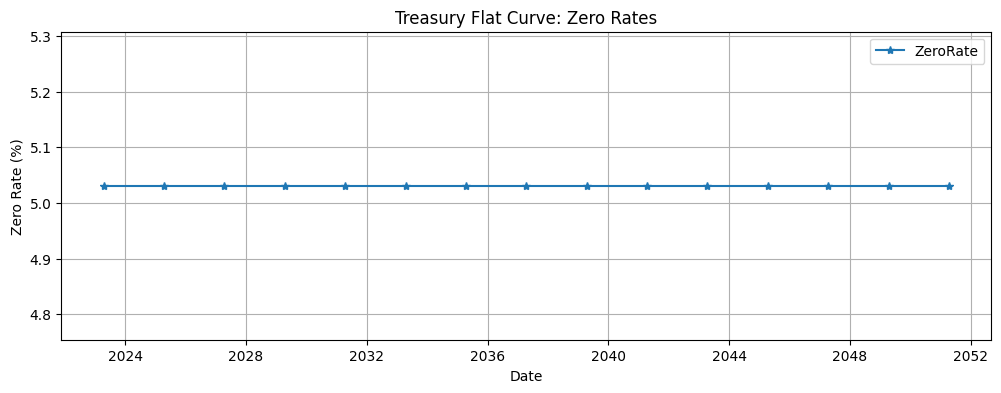

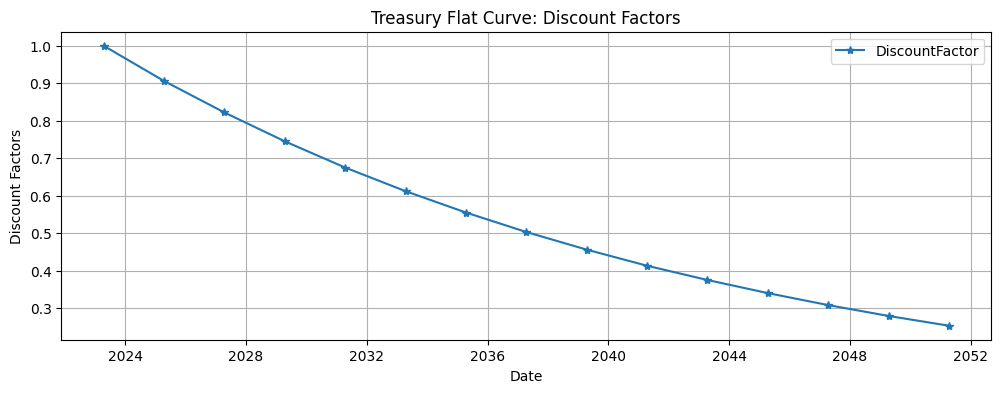

In [26]:
plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='Treasury Flat Curve: Zero Rates', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='Treasury Flat Curve: Discount Factors', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## 11. SOFR OIS swap rates and SOFR discount curve calibration + validation

### a. SOFR curve calibration (via Bootstrapping)

Overnight Index Swap contract is an interest rate swap contract exchanging and overnight index interest rate (e.g. Fed Funds, SOFR, LIBOR) for a fixed interest rate until the contract maturity. The fixed rate is set at a rate agreed upon by both parties. The floating leg portion of the swap is compounded and paid at reset dates. 

In [27]:
# settle_days
settle_days = 2

# SOFR OIS swap tenors: 1Y, 2Y, 3Y, 5Y 7Y, 10Y, 20Y and 30Y
SOFR_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10, 20, 30]]
               
# SOFR OIS swap rates (as of 2023-04-14)
SOFR_rates = [4.81, 4.11, 3.73, 3.38, 3.32, 3.26, 3.20, 3.02]

SOFR_OIS_swap_helpers = []
for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):
    SOFR_OIS_swap_helpers.append(ql.OISRateHelper(settle_days, SOFR_tenor, ql.QuoteHandle(ql.SimpleQuote(SOFR_rate/100)), ql.Sofr()))

# Create SOFR yield curve
sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, SOFR_OIS_swap_helpers, ql.Actual360())
sofr_yield_curve.enableExtrapolation()
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

print(sofr_yield_curve.referenceDate())


April 18th, 2023


### b. Display the calibrated SOFR discount curve dataframe

In [28]:
# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-04-18     0.000           1.000     4.808
1  2024-04-18     1.017           0.953     4.808
2  2025-04-21     2.039           0.921     4.094
3  2026-04-20     3.050           0.895     3.706
4  2028-04-18     5.075           0.846     3.347
5  2030-04-18     7.103           0.795     3.291
6  2033-04-18    10.147           0.724     3.232
7  2043-04-20    20.297           0.530     3.173
8  2053-04-18    30.439           0.415     2.931
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-04-18     0.000           1.000     4.808
1   2025-04-18     2.031           0.922     4.100
2   2027-04-18     4.058           0.869     3.527
3   2029-04-18     6.089           0.820     3.319
4   2031-04-18     8.117           0.770     3.272
5   2033-04-18    10.147           0.724     3.232
6   2035-04-18    12.175           0.680     3.221
7   2037-04-18    14.206           0.638     3.209
8   2039-04-18    16.233           0.600 

### c. Plot the calibrated SOFR Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

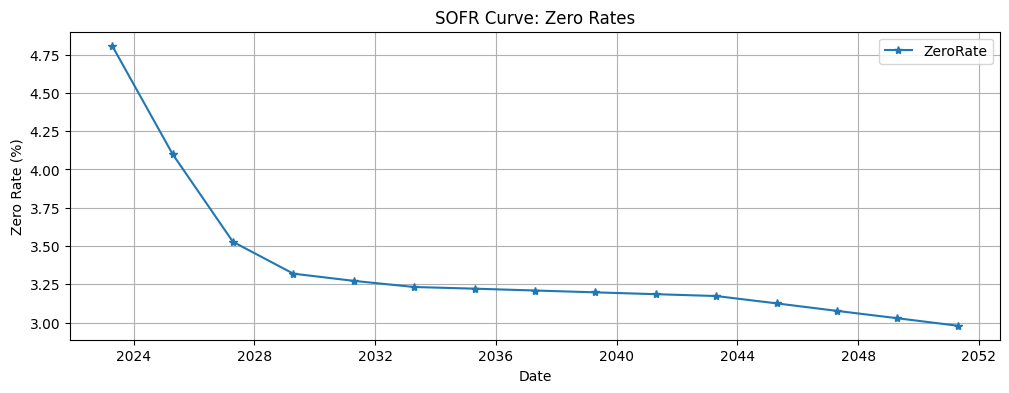

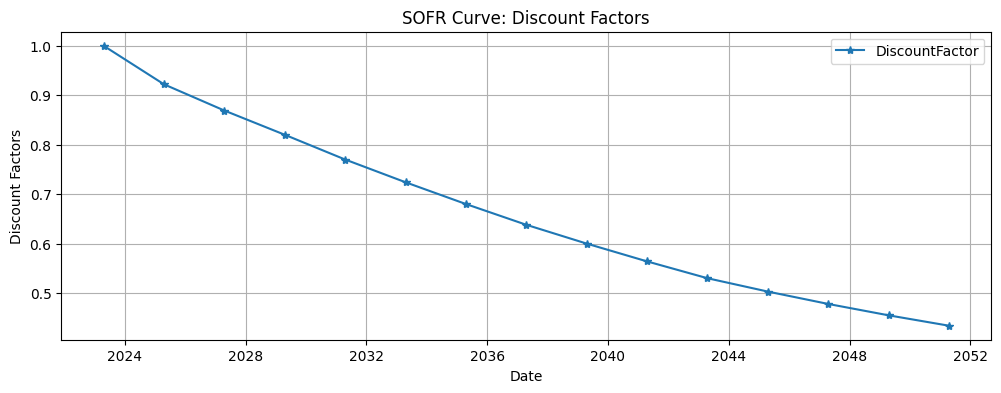

In [29]:
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

### d. Validate SOFR calibration by pricing SOFR swaps

In [30]:
# validate SOFR swaps
sofr_index = ql.Sofr(sofr_yield_curve_handle)
# swap_engine = ql.DiscountingSwapEngine(sofr_yield_curve_handle)

print('SOFR Swap valuation: PVs should be close to zero!')

for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):    
    start_date = calendar.advance(calc_date, settle_days, ql.Days)
    schedule = ql.MakeSchedule(start_date, calendar.advance(start_date, SOFR_tenor), ql.Period('1Y'), calendar=calendar)        
    oisSwap = ql.MakeOIS(SOFR_tenor, sofr_index, SOFR_rate/100, nominal=100)
    
    # oisSwap.setPricingEngine(swap_engine)
    print('Swap PV for', SOFR_tenor, 'tenor /', SOFR_rate, 'coupon :', oisSwap.NPV()) 
    

SOFR Swap valuation: PVs should be close to zero!
Swap PV for 1Y tenor / 4.81 coupon : 0.0
Swap PV for 2Y tenor / 4.11 coupon : 2.842170943040401e-14
Swap PV for 3Y tenor / 3.73 coupon : -4.263256414560601e-14
Swap PV for 5Y tenor / 3.38 coupon : -4.033573475226149e-11
Swap PV for 7Y tenor / 3.32 coupon : -2.842170943040401e-14
Swap PV for 10Y tenor / 3.26 coupon : 7.105427357601002e-15
Swap PV for 20Y tenor / 3.2 coupon : -2.1316282072803006e-14
Swap PV for 30Y tenor / 3.02 coupon : -6.394884621840902e-14


## 12. CDS Hazard Rate calibration + pricing
### a. CDS Hazard Rate calibration


In [31]:
CDS_recovery_rate = 0.4

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2023-04-14
CDS_spreads = [17.25, 24.09, 35.58, 55.58, 70.51, 79.92]

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, ql.Actual360(), CDS_recovery_rate, sofr_yield_curve_handle)
               
for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, ql.Actual360())
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), hr[1] * 100, hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]
grid_dates, hazard_rates, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'HazardRate': hazard_rates,
                                     'SurvivalProb': surv_probs})
print(hazard_rates_df)


         Date  HazardRate  SurvivalProb
0  2023-04-14    0.285237      1.000000
1  2024-06-20    0.285237      0.996575
2  2025-06-20    0.540041      0.991133
3  2026-06-22    1.033609      0.980745
4  2028-06-20    1.511140      0.951188
5  2030-06-20    1.925096      0.914772
6  2033-06-20    1.803340      0.865903


### b. Plot the calibrated Hazard Rate and Survival Probability curves

Text(0.5, 0, 'Date')

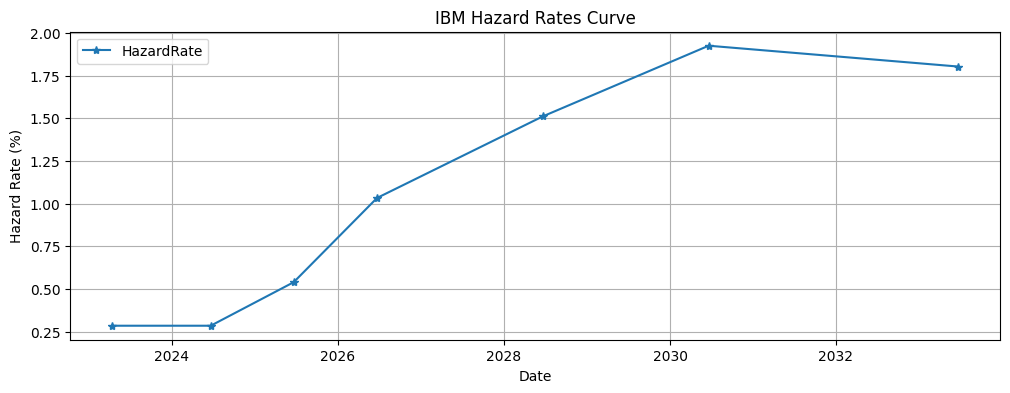

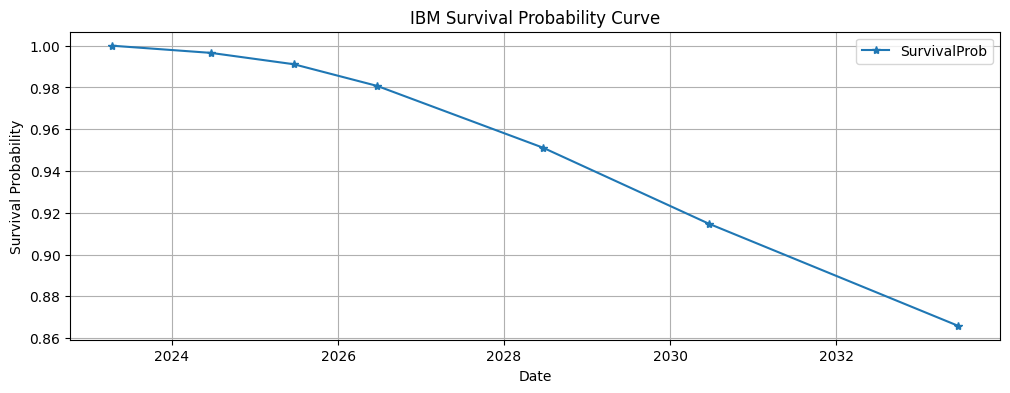

In [32]:
plt = hazard_rates_df.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(12,4))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(12,4))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


### c. CDS valuation

In [33]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(14, 4, 2023)
cds_maturity_date = ql.Date(20, 6, 2028)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS pricing engine
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: April 14th, 2023
CDS fair/par spread: 55.502
CDS PV: 2.0855
CDS Premium Leg PV: 4.6868
CDS Default Leg PV -2.6013
Survival Prob. to Maturity: 0.9512
